In [8]:
from cfl.experiment import Experiment
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from cfl_helpers import *

In [9]:
resolution = '80km'
train_file = f'data/{resolution}_data.csv'
test_file = f'data/13km_truth.csv'

train_data = pd.read_csv(train_file)
trainX, trainY = np.array(train_data[['lat', 'long']]), np.array(train_data['generated_temp']).reshape(-1,1)
trainX = StandardScaler().fit_transform(trainX)
trainY = StandardScaler().fit_transform(trainY)

test_data = pd.read_csv(test_file)
del test_data['elevation']
testX, testY = np.array(test_data[['lat', 'long']]), np.array(test_data['generated_temp']).reshape(-1,1)
testX = StandardScaler().fit_transform(testX)
testY = StandardScaler().fit_transform(testY)

print('Training data shape:', trainX.shape, trainY.shape)
print('Test data shape:', testX.shape, testY.shape)

Training data shape: (200, 2) (200, 1)
Test data shape: (7487, 2) (7487, 1)


In [10]:
data_info = {'X_dims' : trainX.shape,
             'Y_dims' : trainY.shape,
             'Y_type' : 'continuous' #options: 'categorical' or 'continuous'
            }

CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    # model architecture
                    'dense_units' : [50, data_info['Y_dims'][1]],
                    'activations' : ['relu', 'linear'],
                    'dropouts'    : [0, 0],
                    # training parameters
                    'batch_size'  : 64,
                    'n_epochs'    : 2000,
                    'optimizer'   : 'adam',
                    'opt_config'  : {'lr' : 1e-4},
                    'loss'        : 'mean_squared_error',
                    'best'        : True,
                    'early_stopping' : True,
                    # verbosity
                    'verbose'     : 0, # don't log or show plot for checking clusters vs accuracy
                    'show_plot'   : False,
                }
}

# CAUSE CLUSTER PARAMS VARIED

In [11]:
'''
# old tests for checking clusters

cause_cluster_params =  {'model' : 'KMeans',
                        'model_params' : {'n_clusters' : 10},
                        'verbose' : 0
}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]
results_path = 'sample' # directory to save results to

my_exp = Experiment(X_train=trainX,
                    Y_train=trainY,
                    data_info=data_info,
                    block_names=block_names,
                    block_params=block_params,
                    results_path=results_path)
results = my_exp.train()
xlbls = results['CauseClusterer']['x_lbls']

my_exp.add_dataset(X=testX, Y=testY, dataset_name='test_data')
pred_results = my_exp.predict('test_data')
pred_xlbls = pred_results['CauseClusterer']['x_lbls']

# print(xlbls) # on 40km dataset
train_lbl_avg, train_lbl_dict = get_group_avgs(train_data, xlbls)
print(train_lbl_avg)
train_counts = {i: len(train_lbl_dict[i]) for i in range(10)}
counts_sum = sum(train_counts.values())
train_counts_prop = {k: round(v / counts_sum, 2) for k, v in train_counts.items()}
print(train_counts_prop)

test_lbl_avg, test_lbl_dict = get_group_avgs(test_data, pred_xlbls)
preds = list(pred_xlbls)

print()
print(test_lbl_avg)
test_counts = {i: len(test_lbl_dict[i]) for i in range(10)}
counts_sum = sum(test_counts.values())
test_counts_prop = {k: round(v / counts_sum, 2) for k, v in test_counts.items()}
print(test_counts_prop)
'''

"\n# old tests for checking clusters\n\ncause_cluster_params =  {'model' : 'KMeans',\n                        'model_params' : {'n_clusters' : 10},\n                        'verbose' : 0\n}\n\nblock_names = ['CondDensityEstimator', 'CauseClusterer']\nblock_params = [CDE_params, cause_cluster_params]\nresults_path = 'sample' # directory to save results to\n\nmy_exp = Experiment(X_train=trainX,\n                    Y_train=trainY,\n                    data_info=data_info,\n                    block_names=block_names,\n                    block_params=block_params,\n                    results_path=results_path)\nresults = my_exp.train()\nxlbls = results['CauseClusterer']['x_lbls']\n\nmy_exp.add_dataset(X=testX, Y=testY, dataset_name='test_data')\npred_results = my_exp.predict('test_data')\npred_xlbls = pred_results['CauseClusterer']['x_lbls']\n\n# print(xlbls) # on 40km dataset\ntrain_lbl_avg, train_lbl_dict = get_group_avgs(train_data, xlbls)\nprint(train_lbl_avg)\ntrain_counts = {i: le

In [12]:
# n_clusters = [1, 5, 10, 30, 50, 75, 100, 150, 200] # for 10km
# n_clusters = [1, 3, 5, 7, 10, 15, 20, 30, 50, 100, 200] # for 25km
n_clusters = [1, 2, 3, 5, 7, 10, 15, 20, 30, 40, 50] # for 40km

train_errs = []
test_errs = []

for n in n_clusters:
    cause_cluster_params =  {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : n},
                         'verbose' : 0
    }

    block_names = ['CondDensityEstimator', 'CauseClusterer']
    block_params = [CDE_params, cause_cluster_params]
    results_path = 'sample_run_2' # directory to save results to

    my_exp = Experiment(X_train=trainX,
                        Y_train=trainY,
                        data_info=data_info,
                        block_names=block_names,
                        block_params=block_params,
                        results_path=results_path)
    results = my_exp.train()
    xlbls = results['CauseClusterer']['x_lbls']
    train_errs.append(by_point_err(train_data, xlbls, train_data, xlbls))

    my_exp.add_dataset(X=testX, Y=testY, dataset_name='test_data')
    pred_results = my_exp.predict('test_data')
    pred_xlbls = pred_results['CauseClusterer']['x_lbls']
    test_errs.append(by_point_err(train_data, xlbls, test_data, pred_xlbls))

    print(f'train err for {n} clusters: {train_errs[-1]}')
    print(f'test err for {n} clusters: {test_errs[-1]}')


All results from this run will be saved to sample_run_2/experiment0097
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
7/7 [==============================] - 0s 945us/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.
Beginning Experiment prediction.
Beginning CondDensityEstimator prediction...
234/234 [==============================] - 0s 764us/step
CondDensityEstimator prediction complete.
Beginning CauseClusterer prediction...
CauseClusterer prediction complete.
Prediction complete.
train err for 1 clusters: 2.870093684931027
test err for 1 clusters: 3.1826035753714903
All results from this run will be saved to sample_run_2/experiment0098
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
7/7 [===

[2.870093684931027, 2.6615978922417156, 2.056950257520277, 1.8459619906197988, 2.3602909398967227, 2.201308711502741, 1.6941450543878345, 1.8907238100395047, 1.6079617373868427, 1.885728631369181, 1.3203211824697947]
[3.1826035753714903, 3.1050480986993847, 2.62284448332546, 2.4284126582773147, 2.995371781308105, 2.878044602394514, 2.5090732887964675, 2.752195925405511, 2.8349783046566808, 3.4194959788930905, 2.8140826178231118]


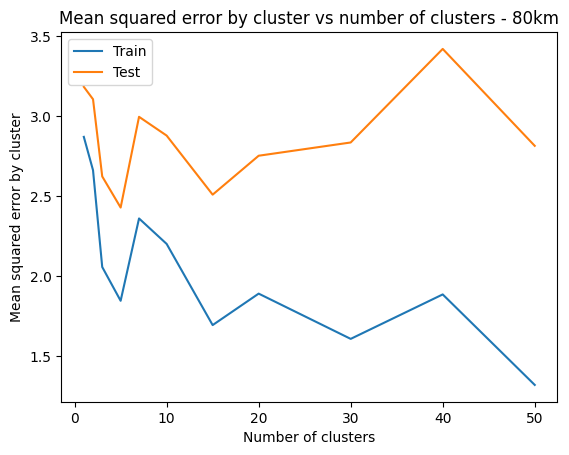

In [13]:
import matplotlib.pyplot as plt

print(train_errs)
print(test_errs)

plt.figure(0)
plt.plot(n_clusters, train_errs, label='Train')
plt.plot(n_clusters, test_errs, label='Test')
plt.xlabel('Number of clusters')
plt.ylabel('Mean squared error by cluster')
plt.legend()
_ = plt.title(f'Mean squared error by cluster vs number of clusters - {resolution}')

In [14]:
print(xlbls)
print(pred_xlbls)

[ 3 26 35 22 46 15 44 44  9  3 30 24 33 14 14  9 38 43 38  1 44 41  9 38
 21 22 46 47 41  9  3 19 30 24 49 14 33 36 25 12  4 43  3 37  5 49 13 34
  4 12 25 16 11 15 47  8  7 10 48 10 39 46 33 15 11 16  2 27 40 19 30 23
 28 33 37 13 18  4 20  6 42 18  8 37 28  9 46 22  4 20  6 42 18 24  1 37
  9  1 22  4 20 48 19 30 13 26  1 28  1 22  4 20 12 21 39 24 26  1  1 23
 22  4 20  4 43 38 23 11  1 11 36  7  4 20 10  7 24 26  1 26 24 16 34  4
  0  2 38 26 37 28 46  3  7 25 27  0 30 24  9 33 28  8 16 34 10 12  0 16
 26 35 15 37 24 39 25 42 32 20 13  9 31 35  1 13  7 21 27 40 29 11 47 31
 15 26 36 18 10 32 17 45]
[37  9 33 ... 32  6 40]
